# Stock Correlation

This notebook analyses an often heard hypothesis of stock correlations: There are stocks which follow in their trends one after an other within a short time window. If such correlations are predictable, we can exploit them for buy/sell signals. 

Our analysis looks for such correlations and discuss whether they are predictable.

## Statistical Analyses

In the naive approach, we ignore timeseries modeling. Instead, we perform statistical analyses on corresponding slopes of stocks. Specifically, we ask:

> When we see a slope in stock1, what slope can we expect in stock2 right afterwards?

> When we see a slope in stock1 less / greater than $t$, what is the probability stock2 has a return greater than $x$? 



### Parameters

In [1]:
input_file = './SMI.CH_IXX.DE.parquet'

stock1_name = 'SMI'
stock2_name = 'IXX'

### Imports

In [2]:
#%matplotlib notebook

# libs we need
import pandas as pd
import statsmodels.api as sm
import numpy as np
import statistics
from statsmodels.distributions.empirical_distribution import ECDF

# plotting
import matplotlib.pyplot as plt
import math

# date calculations
from datetime import datetime
from datetime import timedelta

### Load Data

Load data from `.parquet` files

In [3]:
stock_correspond = pd.read_parquet(input_file)

# Summary stats
print('Data rows in {}: {}'.format(input_file, len(stock_correspond)))

Data rows in ./SMI.CH_IXX.DE.parquet: 188750


### Explorative Analysis

In [4]:
# only consider real slopes, i.e. slopes which significantly differ from 0 
stock_correspond = stock_correspond[stock_correspond['H0_rejected_stock2'] == True]
stock_correspond = stock_correspond[stock_correspond['H0_rejected_stock1'] == True]
len(stock_correspond)

96982

In [5]:
slopes = stock_correspond[['slope_stock1', 'slope_stock2', 'win_length_stock1', 'win_length_stock2', 'return_stock2']].reset_index(drop=True)
slopes['win_diff'] = slopes['win_length_stock1'] - slopes['win_length_stock2']

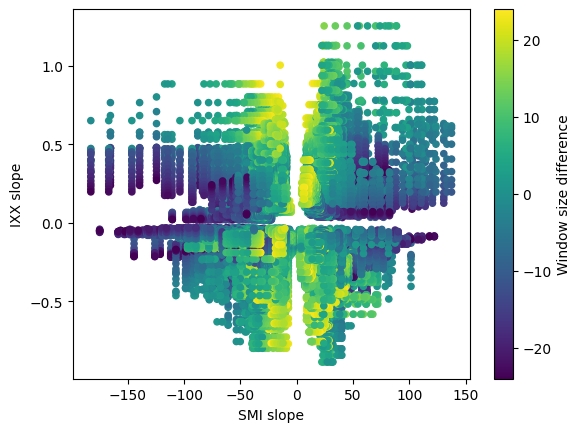

In [6]:
#fig, ax1 = plt.subplots()
ax1 = slopes.plot.scatter(x='slope_stock1', y='slope_stock2', color='win_diff', colormap='viridis')
ax1.set_xlabel('{} slope'.format(stock1_name))
ax1.set_ylabel('{} slope'.format(stock2_name))
cb = ax1.collections[-1].colorbar
cb.set_label('Window size difference')

It's rather dense. Let's draw random samples to work through the structure.

In [7]:
# increase sample size by sample_factor in each sample round
sample_factor = 1000
sample_rounds = int(len(stock_correspond) / sample_factor)

slopes_sample = []
for sample_no in range(sample_rounds):
    slopes_sample.append( slopes.sample(n=sample_factor*(sample_no+1), random_state=1) )

In [8]:
# now, we have many sample rounds, 
# so select only few of them using a fibonacci series
def fib(n):
    a, b = 0, 1
    for _ in range(n):
        yield a
        a, b = b, a + b

def max_fib_num(max_n):
    for r in range(1,sample_rounds):
        if (list(fib(r))[-1] < max_n):
            continue
        return fib(r-1)

slope_sample_nums = list(set(max_fib_num(sample_rounds)))
slope_sample_nums.sort()

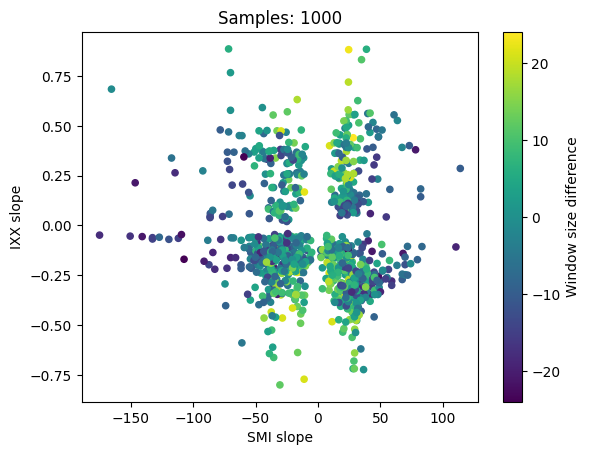

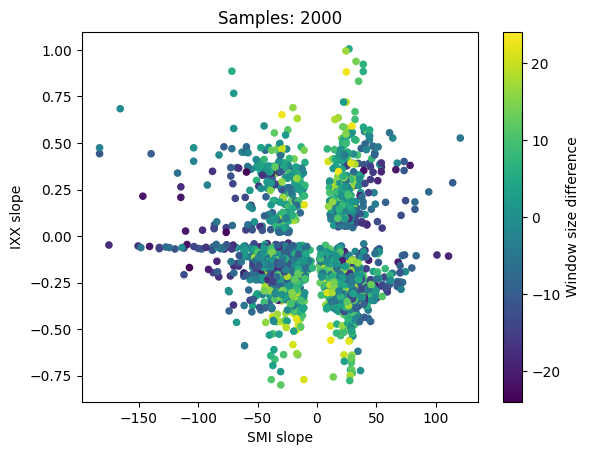

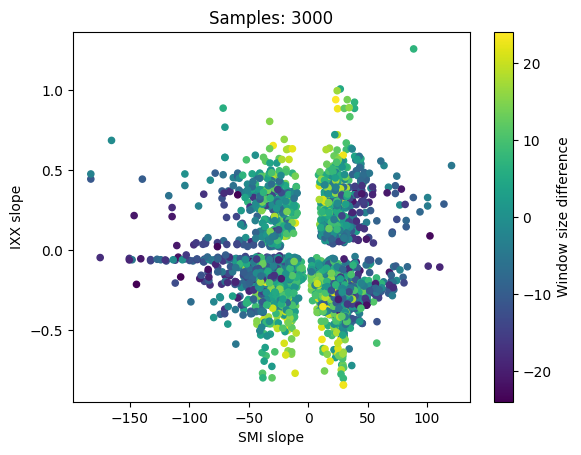

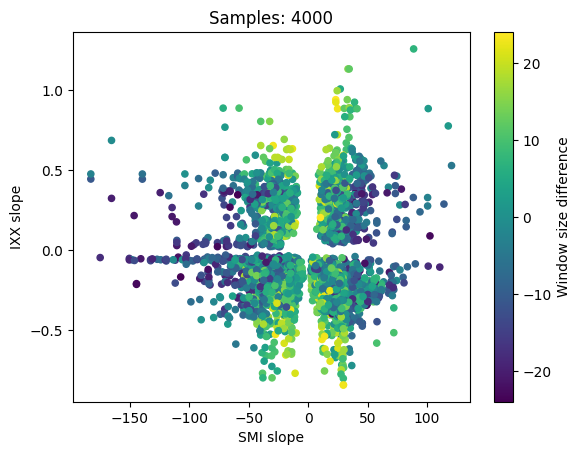

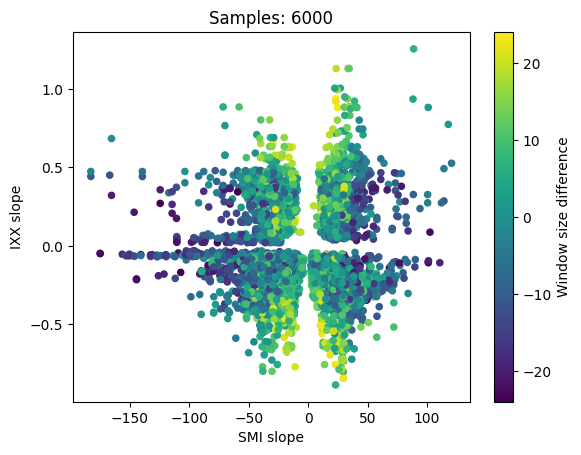

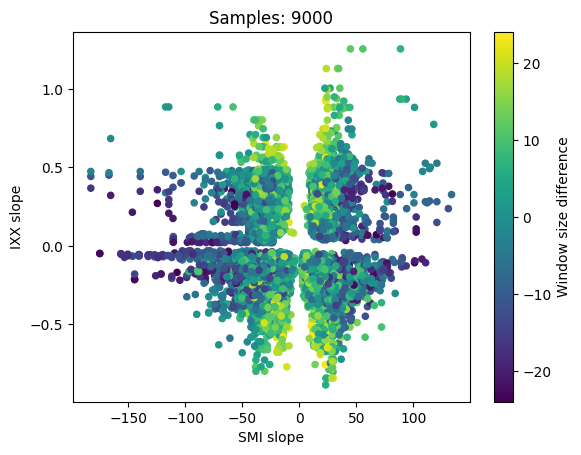

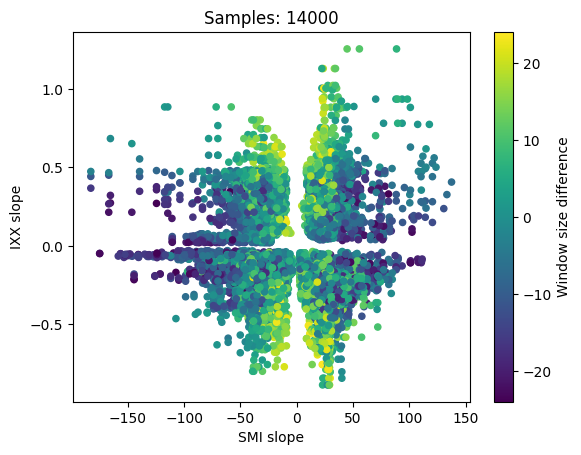

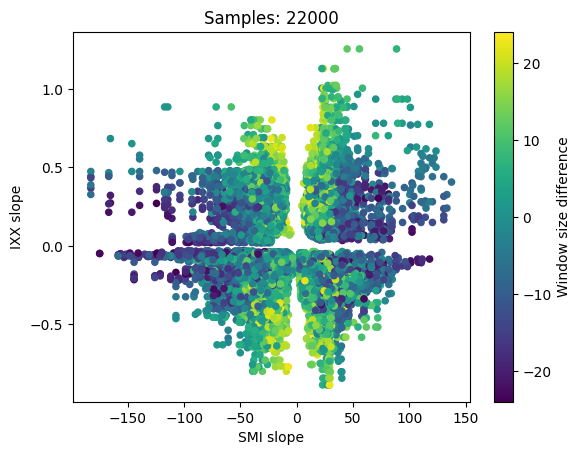

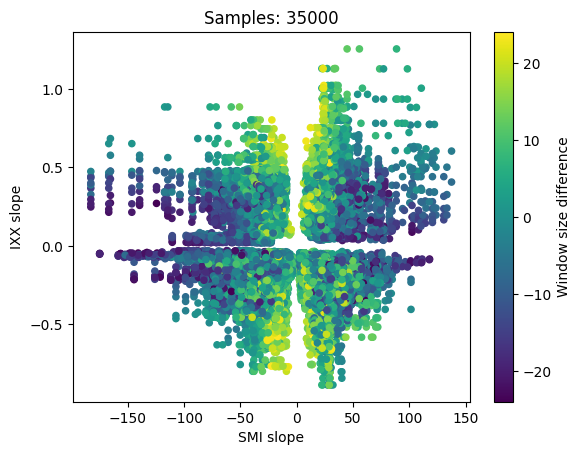

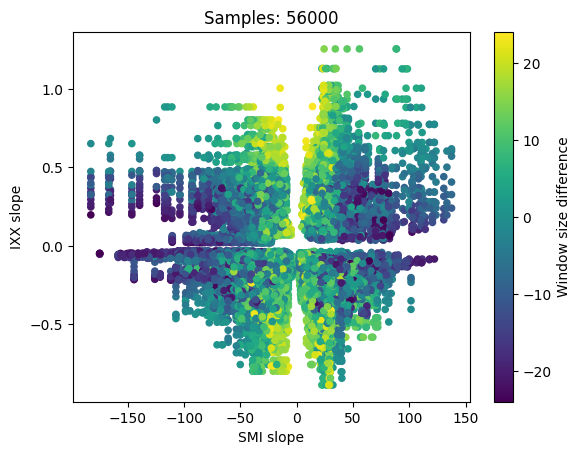

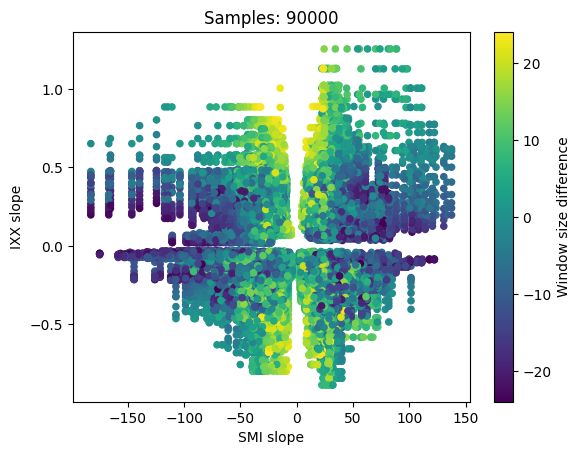

In [9]:
# draw the selected sample rounds 
for i in slope_sample_nums:
    ax1 = slopes_sample[i].plot.scatter(x='slope_stock1', y='slope_stock2', color='win_diff', colormap='viridis')
    ax1.set_xlabel('{} slope'.format(stock1_name))
    ax1.set_ylabel('{} slope'.format(stock2_name))
    ax1.set_title('Samples: {}'.format((i+1)*sample_factor))
    cb = ax1.collections[-1].colorbar
    cb.set_label('Window size difference')    

In the above plot, one can easily see 4 areas around $(0,0)$. However, the upper both are not symmetric to the lower ones. Both lower ones seem to be almost symmetrical, mirrored along the vertical axis through $(0,0)$.

_Future idea:_ automatically identify such extraordinary (i.e. non-symmetrical) areas by a k-means clustering with 4 clusters. Analyze how the 4 cluster centers deviate from a ideal position.

### Probabilities

If stock1 slopes exceed certain limits $c$, slopes and returns for stock2 will not lay in the areas expected from the symmetry. Let's compute some probabilities for these cases.

Defintions:

* Random variable $S_i$ slope of stock $i$
* Random variable $R_i$ return of stock $i$
* Threshold limit $c$ a scalar parameter 

We are interested in the conditional probabilities given a threshold limit $c$

1. $P(S_2 | S_1 \gt c)$ and $P(R_2 | S_1 \ge c)$, if $c \ge 0$
1. $P(S_2 | S_1 \lt c)$ and $P(R_2 | S_1 \lt c)$, if $c \lt 0$

We create an empirical CDF $F_{Var}(x)$ for the random variables $S_2$ and $R_2$ conditioned on the threshold $S_1 \ge c$.

It is $P(S_2 \leq x | S_1 \ge c) = F_{S_2}(x)$ for $F_{S_2}$ given as empirical CDF as above. We can now answer questions about the probability to see an increase or return larger than x for the second stock.

$$
P(S_2 > x | S_1 \ge c) = 1 - P(S_2 \leq x | S_1 \ge c) = F_{S_2}(x)
$$

Apply the same for $R_2$ instead of $S_2$ as well as for the threshold $c \lt 0$.


### Systematic Analysis of Probabilities conditioned by Threshold Limits

We now run through a range of thresholds limits $c$ for stock1 slope, i.e. we define expression $cond$ 

$$
cond = \begin{cases}
S_1 \lt c \textrm{, if } c < 0 \\
S1 \ge c \textrm{, if } c \ge 0
\end{cases}
$$

We evaluate the following probabilities conditioned on the expression $cond$:

* $P(S_2 \le 0 | cond)$, i.e. the probability that stock2 is decreasing
* $P(R_2 > x | cond )$, i.e. the probability that stock2's return exceeds x

We scatter plot both probabilities depending on $cond$.

In [10]:
# define thresholds as generators
num_thresholds = 80
min_slope = min(list(slopes['slope_stock1']))
max_slope = max(list(slopes['slope_stock1']))
thr_limits = list(np.linspace(min_slope,max_slope,num_thresholds))
# remove first and last 10 thresholds
thr_limits = thr_limits[10:-10]
# stock2 returns as x
x_stock2_returns = [round(0.05*i,2) for i in range(0, 20)]

In [11]:
# 1. select threshold
# 2. build data exceeding threshold
# 3. build ECDF for slope and return from data
# 4. Compute probabilities 

In [12]:
# build dataframe structure to store all results
columns = ['thr_stock1']
for x in x_stock2_returns:
    if (x==0):
        columns.append('P(S2<='+str(x)+')') 
    else:
        columns.append('P(R2>'+str(x)+')') 
stock2_returns = pd.DataFrame(columns=columns)

for c in thr_limits:
    # build data for selected threshold
    if (c < 0):
        slopes_stock1 = slopes[slopes['slope_stock1'] < c]
    else:
        slopes_stock1 = slopes[slopes['slope_stock1'] >= c]
    # Create empirical CDF
    ecdf_slope_stock2 = ECDF(slopes_stock1['slope_stock2'])
    ecdf_return_stock2 = ECDF(slopes_stock1['return_stock2'])
    prob = list()
    prob.append(c)
    # Compute probabilities
    for x in x_stock2_returns:
        if (x == 0):
            # Probability of stock2 decreasing
            prob.append(ecdf_slope_stock2(x))
        else:
            # Probability of stock2 return > x
            prob.append(1-ecdf_return_stock2(x))
    stock2_returns = pd.concat([stock2_returns, pd.DataFrame([prob], columns=columns)])

In [13]:
stock2_returns = stock2_returns.reset_index(drop=True)
stock2_returns.head()

,thr_stock1,P(S2<=0.0),P(R2>0.05),P(R2>0.1),P(R2>0.15),P(R2>0.2),P(R2>0.25),P(R2>0.3),P(R2>0.35),P(R2>0.4),...,P(R2>0.5),P(R2>0.55),P(R2>0.6),P(R2>0.65),P(R2>0.7),P(R2>0.75),P(R2>0.8),P(R2>0.85),P(R2>0.9),P(R2>0.95)
0,-142.360808,0.532663,0.467337,0.422111,0.346734,0.190955,0.125628,0.065327,0.025126,0.020101,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-138.304222,0.526316,0.473684,0.437247,0.376518,0.246964,0.178138,0.105263,0.040486,0.032389,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-134.247635,0.561798,0.438202,0.404494,0.348315,0.228464,0.164794,0.097378,0.037453,0.029963,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-130.191048,0.608696,0.391304,0.361204,0.311037,0.204013,0.147157,0.086957,0.033445,0.026756,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-126.134462,0.659884,0.340116,0.313953,0.270349,0.177326,0.127907,0.075581,0.029070,0.023256,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Text(0.5, 1.0, 'Probability that IXX achieves return greater 10%')

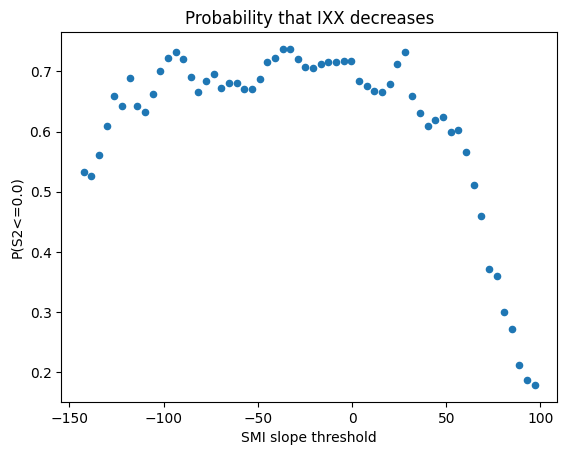

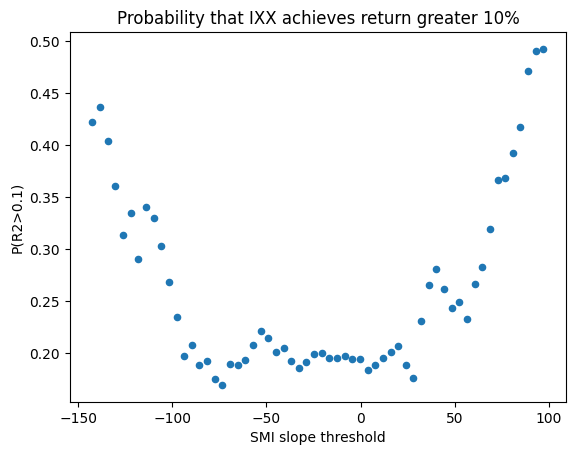

In [14]:
ax1 = stock2_returns.plot.scatter(x='thr_stock1', y='P(S2<=0.0)')
ax1.set_xlabel('{} slope threshold'.format(stock1_name))
ax1.set_title('Probability that {} decreases'.format(stock2_name))

ax1 = stock2_returns.plot.scatter(x='thr_stock1', y='P(R2>0.1)')
ax1.set_xlabel('{} slope threshold'.format(stock1_name))
ax1.set_title('Probability that {} achieves return greater 10%'.format(stock2_name))

### Results and Discussion

We start with some conrete example results derived from the systematic analysis. In all examples, we provide results under the condition $S_1 \ge c$, where $c$ is the last threshold limit from previous analysis.

At the end, we also discuss quality of our results for prediction tasks.

In [15]:
# the slope threshold we use for all result discussions
c = thr_limits[-1]

In [16]:
print('In the case, the {} slope is larger than {}, we find:\n'.format(stock1_name,c))

# Compute probabilities
row = stock2_returns[stock2_returns['thr_stock1'] == c]
x = 0.0
prob = row['P(S2<={})'.format(x)].iloc[0]
print('\t* Probability of {} decreasing is {}%.'.format(stock2_name, round(prob*100,2)))
x_stock2_returns = [0.05, 0.1, 0.15, 0.2]
for x in x_stock2_returns:
    prob = row['P(R2>{})'.format(x)].iloc[0]
    print('\t* Probability of {} return > {}% is {}%.'.format(stock2_name, x*100, round(prob*100,2)))

In the case, the SMI slope is larger than 96.97780029113733, we find:

	* Probability of IXX decreasing is 17.89%.
	* Probability of IXX return > 5.0% is 76.83%.
	* Probability of IXX return > 10.0% is 49.27%.
	* Probability of IXX return > 15.0% is 19.94%.
	* Probability of IXX return > 20.0% is 6.45%.


Let's plot the distributions of stock2's slopes and returns.

In the case, the SMI slope is larger than 96.97780029113733, we find:

Avg. slope of IXX: 0.3462422317926271
Avg. return of IXX: 0.09192575413037665


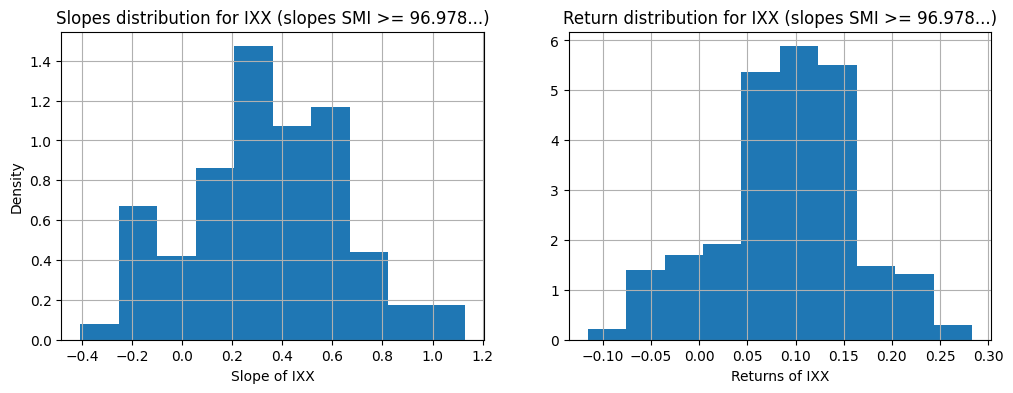

In [17]:
# select the results for stock1's slope exceeding c
slopes_stock1_gt_c = slopes[slopes['slope_stock1'] > c]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
slopes_stock1_gt_c.slope_stock2.hist(density=True, ax=axes[0])
axes[0].set_title('Slopes distribution for {} (slopes {} >= {}...)'.format(stock2_name, stock1_name, round(c,3)))
axes[0].set_xlabel('Slope of {}'.format(stock2_name))
slopes_stock1_gt_c.return_stock2.hist(density=True, ax=axes[1])
axes[1].set_title('Return distribution for {} (slopes {} >= {}...)'.format(stock2_name, stock1_name, round(c,3)))
axes[1].set_xlabel('Returns of {}'.format(stock2_name))
axes[0].set_ylabel('Density')

# Some stats for both
mean_slope_stock2 = statistics.mean(slopes_stock1_gt_c['slope_stock2'])
mean_return_stock2 = statistics.mean(slopes_stock1_gt_c['return_stock2'])

print('In the case, the {} slope is larger than {}, we find:\n'.format(stock1_name,c))
print('Avg. slope of {}: {}'.format(stock2_name, mean_slope_stock2))
print('Avg. return of {}: {}'.format(stock2_name, mean_return_stock2))

At the first glance, the findings from above look promising. However, these results look into the past. They do not tell us anything about the prediction quality. 
Firstly, it is rather rare for stock's slope to exceed the threshold from the above example. Secondly, slopes exceeding the thresholds may have just occured in the near past. Previous to that the slopes may have not shown this behavior.

As a consequence, we have additional requirements.

1. Split data into two sets: one for analysis and one for testing the analysis results. 
1. Conditions, e.g. slopes exceeding the thresholds, are not just found in one short time intervall over all observation. Rather, these conditions shall be distributed across all observations from analysis data set.

Just to illustrate the discussion on the prediction quality, we show how rare slopes with a threshold limit larger than $c$ are. 

In [18]:
# slopes exeeding thresholds are rare
num_obs = len(set(stock_correspond.reset_index()['date_stock1'])) 
s = stock_correspond.reset_index()[['date_stock1', 'slope_stock1']]
s = s[s['slope_stock1'] >= c]
num_slopes = len(set(s['date_stock1']))

print('Number of observation days: \t\t{}'.format(num_obs))
print('Number of slopes exceeding {}: \t{}'.format(round(c,3),num_slopes))

Number of observation days: 		317
Number of slopes exceeding 96.978: 	9


How do the days with exceedings slopes distribute across all observations days? Do they cluster?

In [19]:
stock1_dates = list(set(stock_correspond.reset_index()['date_stock1']))
stock1_dates.sort()
not_exceeds_c = [False] * len(stock1_dates)
df_not_exceeds_c = pd.DataFrame(data=not_exceeds_c, index=stock1_dates, columns=['not_exceeds_c'])

slope_dates = list(set(s['date_stock1']))
slope_dates.sort()
exceeds_c = [True] * len(slope_dates)
df_exceeds_c = pd.DataFrame(data=exceeds_c, index=slope_dates, columns=['exceeds_c'])

In [20]:
print('The dates where the {} slopes >= {}'.format(stock1_name, c))
slope_dates

The dates where the SMI slopes >= 96.97780029113733


['2021-12-02',
 '2022-03-04',
 '2022-03-07',
 '2022-03-08',
 '2022-03-09',
 '2022-03-10',
 '2022-03-11',
 '2022-03-14',
 '2022-03-15']

Visualize above dates using a histogram across all observation days.

In [21]:
# join frames together and replace all NaN with False
df = df_not_exceeds_c.join(df_exceeds_c).fillna(False)
df = df.drop(['not_exceeds_c'], axis=1)
df = df.reset_index() # retrieve date from stock1
df = df.rename(columns={'index':'date_stock1'})
df = df.assign(days_back=list(range(-len(df)+1,1))) # enumerate date as dates in the past

Text(0.5, 0, 'Days back from last observation day 2022-12-07')

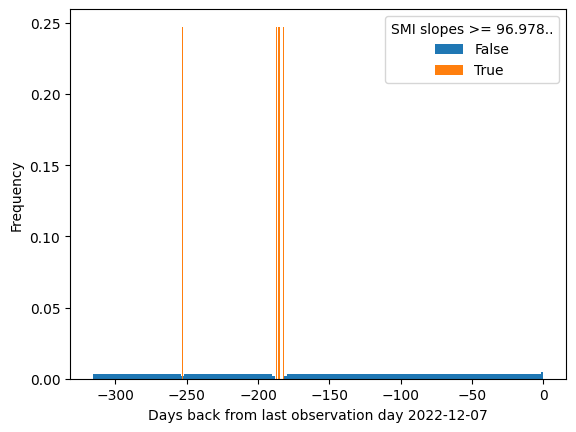

In [22]:
# plot as histogram
df.groupby('exceeds_c')['days_back'].plot(kind='hist', bins=int(len(df)/2), density=True)
plt.legend(['False', 'True'], title='{} slopes >= {}..'.format(stock1_name, round(c,3)))
plt.xlabel('Days back from last observation day {}'.format(stock1_dates[-1]))

### Function fitting (work-in-progress)

In [ ]:
sample = slopes['slope_stock1']

In [ ]:
dist_continuous = [d for d in dir(stats) if isinstance(getattr(stats, d), stats.rv_continuous)]
dist_discrete = [d for d in dir(stats) if isinstance(getattr(stats, d), stats.rv_discrete)]
list_of_dists = dist_discrete + dist_continuous

In [ ]:
results = []
for i in list_of_dists:
    dist = getattr(stats, i)
    try:
        param = dist.fit(sample)
    except:
        continue
    a = stats.kstest(sample, i, args=param)
    results.append((i,a[0],a[1]))
    
    
results.sort(key=lambda x:float(x[2]), reverse=True)
for j in results:
    print("{}: statistic={}, pvalue={}".format(j[0], j[1], j[2]))

In [ ]:
results